In [3]:
import pandas as pd
import os
from matplotlib import pyplot
import math
from matplotlib.pyplot import figure
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from google.cloud import storage
from google.cloud.storage import Blob

In [200]:
dir_files = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/tmp/') if not n in ['.ipynb_checkpoints', 'Untitled.ipynb', 'TMalign.cpp', 'blast_annotations.parquet']]
res = pd.DataFrame(None)

for file in dir_files:
    res = res.append(pd.read_parquet(f'/home/jupyter/pss/tmp/{file}.parquet'))

print('Experiment:', len(res), 'out of 59684 processed')
sample_all = pd.read_parquet('/home/jupyter/pss/tmalign_rmsd_full.parquet')
print('Proteome Sample:', len(sample_all))

Experiment: 24607 out of 24607 processed
Proteome Sample: 71300


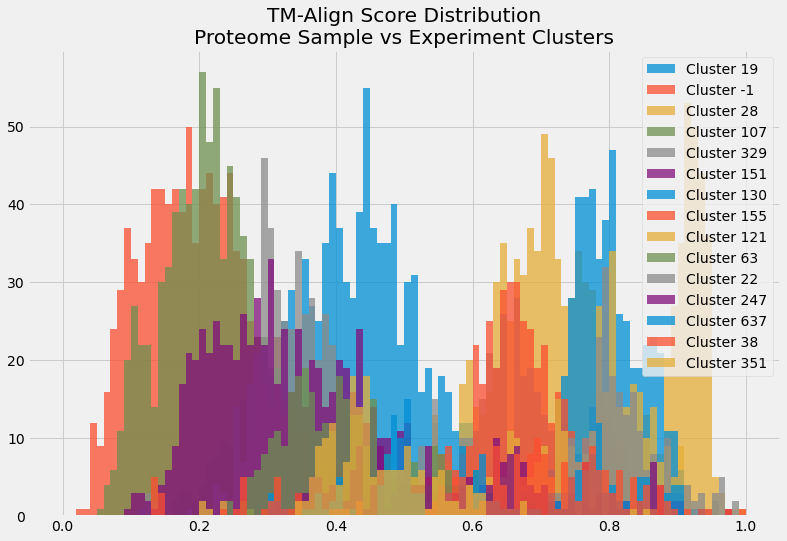

In [201]:
# manual list
#interesting_clusters = [2, 168]

# top n clusters by number of proteins processed in each so far
interesting_clusters = res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(
    by=['target_protein'], ascending=False)[:15].cluster.values

# top n clusters by highest mean tmalign_score in each so far
#interesting_clusters = res[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(
#    by=['tmalign_score'], ascending=False)[:15].cluster.values

# random sample of clusters
#interesting_clusters = res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sample(15).cluster.values

ssize = int(len(res[res.cluster.isin(interesting_clusters)])*1)

figure(figsize=(12, 8))
bin_size = 100
#pyplot.hist(sample_all.sample(ssize).tm_score_norm_ref_p1.astype(float), bins=bin_size, alpha=0.5, label=f'Sample ({ssize} obs.)', range=(0,1))

for cluster in interesting_clusters:
    pyplot.hist(res[res.cluster == cluster].tmalign_score, bins=bin_size, alpha=0.75, label=f'Cluster {cluster}', range=(0,1))

pyplot.style.use('fivethirtyeight')
pyplot.legend(loc='upper right')
pyplot.title('TM-Align Score Distribution\nProteome Sample vs Experiment Clusters')
pyplot.show()

In [202]:
# Highest number of processed protein pairs per cluster
res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['target_protein'], ascending=False)[:10]

,cluster,target_protein
19,19,990
0,-1,989
28,28,982
107,107,920
329,329,883
151,151,713
130,130,533
155,155,408
121,121,359
63,63,341


In [203]:
# Highest mean tmalign scores for processed pairs by cluster
res[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(by=['tmalign_score'], ascending=False)[:10]

,cluster,tmalign_score
811,815,0.999710
1440,1455,0.999680
735,739,0.999533
68,68,0.999270
1025,1033,0.999240
583,586,0.998910
849,854,0.998810
1528,1543,0.998510
237,237,0.998440
140,140,0.998150


In [ ]:
res.drop(['cluster'], axis=1, inplace=True)
sample_all.rename({'tm_score_norm_ref_p1': 'tmalign_score'}, axis=1, inplace=True)
full = sample_all.append(res)
full.drop_duplicates(inplace=True)
full.reset_index(inplace=True)
print(len(full))
table = pa.Table.from_pandas(full)
pq.write_table(table, f'pairwise_evaluation_metrics.parquet')

In [158]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/jupyter/pss/PSS GCS Storage Key.json"
storage_client = storage.Client()

def get_gcs_annotations():
    bucket = storage_client.get_bucket('capstone-fall21-protein')
    blob = Blob("annotations/blast_annotations.parquet", bucket)
    blob.download_to_filename('blast_annotations.parquet')

get_gcs_annotations()

blast = pd.read_parquet('blast_annotations.parquet')
blast

,query_protein,target_protein,query_range,hit_range,hit_span,bitscore,evalue
0,AF-A0A024R1R8-F1-model_v1,AF-Q9Y2S6-F1-model_v1,"(0, 64)","(0, 64)",64,57.4,3.770000e-13
1,AF-A0A024R1R8-F1-model_v1,AF-P98177-F1-model_v1,"(0, 57)","(178, 233)",55,31.2,3.000000e-02
2,AF-A0A024R1R8-F1-model_v1,AF-Q9H7D0-F1-model_v1,"(25, 64)","(1566, 1610)",44,30.4,4.500000e-02
3,AF-A0A024R1R8-F1-model_v1,AF-Q96CB9-F1-model_v1,"(22, 55)","(266, 299)",33,29.3,1.500000e-01
4,AF-A0A024R1R8-F1-model_v1,AF-Q9UPA5-F1-model_v1,"(2, 64)","(817, 880)",63,26.2,1.700000e+00
...,...,...,...,...,...,...,...
7771240,AF-X6R8D5-F1-model_v1,AF-Q6RI45-F1-model_v1,"(17, 61)","(1268, 1317)",49,27.7,2.400000e+00
7771241,AF-X6R8D5-F1-model_v1,AF-Q6PRD1-F1-model_v1,"(12, 50)","(990, 1031)",41,27.7,2.900000e+00
7771242,AF-X6R8D5-F1-model_v1,AF-P30622-F1-model_v1,"(19, 46)","(157, 184)",27,27.3,4.300000e+00
7771243,AF-X6R8D5-F1-model_v1,AF-Q9Y478-F1-model_v1,"(5, 54)","(16, 68)",52,26.2,6.700000e+00


In [148]:
print(len(blast))
print(len(blast[['query_protein', 'target_protein']].drop_duplicates()))

7771245
1963860


In [149]:
print(len(blast.drop_duplicates()))

7771245


In [150]:
blast[blast.query_protein == 'AF-Q96RW7-F1-model_v1']

,query_protein,target_protein,query_range,hit_range,hit_span,bitscore,evalue
6072320,AF-Q96RW7-F1-model_v1,AF-Q8NDA2-F1-model_v1,"(37, 23652)","(33, 23605)",23572,18954.0,0.0
6072321,AF-Q96RW7-F1-model_v1,AF-Q8NDA2-F1-model_v1,"(2937, 24852)","(1643, 23605)",21962,13280.0,0.0
6072322,AF-Q96RW7-F1-model_v1,AF-Q8NDA2-F1-model_v1,"(3052, 24927)","(1665, 23590)",21925,12527.0,0.0
6072323,AF-Q96RW7-F1-model_v1,AF-Q8NDA2-F1-model_v1,"(1957, 23727)","(1680, 23590)",21910,11494.0,0.0
6072324,AF-Q96RW7-F1-model_v1,AF-Q8NDA2-F1-model_v1,"(3724, 24928)","(1681, 23230)",21549,10485.0,0.0
...,...,...,...,...,...,...,...
6166421,AF-Q96RW7-F1-model_v1,AF-Q9Y336-F1-model_v1,"(13429, 13665)","(102, 337)",235,35.0,8.7
6166422,AF-Q96RW7-F1-model_v1,AF-Q9Y336-F1-model_v1,"(14629, 14865)","(102, 337)",235,35.0,8.7
6166423,AF-Q96RW7-F1-model_v1,AF-Q9Y336-F1-model_v1,"(15829, 16065)","(102, 337)",235,35.0,8.7
6166424,AF-Q96RW7-F1-model_v1,AF-Q9Y336-F1-model_v1,"(17029, 17265)","(102, 337)",235,35.0,8.7


In [286]:
import statsmodels.stats.proportion as bni
print('beta / Clopper-Pearson:', bni.proportion_confint(100, 5866, 0.05, 'beta'))

beta / Clopper-Pearson: (0.013891402102990462, 0.02069586262948231)


# Next Steps
* Merge this folder's results into the main tmalign metrics file
* Write code to downsample big clusters (maybe n combinations > 100?) and also mabe to ignore the ~200 big proteins
* Run tmalign (match against main file first, then run tmalign on rest)
* Merge results back into main file
* Merge BLAST stats into tmaligm file

In [204]:
print(len(res))
res.head()

24607


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
0,AF-Q14896-F1-model_v1,1274,AF-Q00872-F1-model_v1,1141,544,6.45,0.34642,969
1,AF-Q9H7D0-F1-model_v1,1870,AF-Q92608-F1-model_v1,1830,1665,4.94,0.80195,1146
2,AF-Q8N7C3-F1-model_v1,387,AF-P08118-F1-model_v1,114,64,4.59,0.12656,-1
3,AF-Q6P093-F1-model_v1,401,AF-Q6PIU2-F1-model_v1,408,394,2.13,0.92819,819
4,AF-Q13046-F1-model_v1,419,AF-Q9UQ72-F1-model_v1,335,257,4.78,0.48327,637


In [205]:
batch_stats = pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

194390


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [206]:
new_batch_stats = batch_stats.append(res.drop(['cluster'], axis=1))
print(len(new_batch_stats))
new_batch_stats.head()

218997


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [207]:
new_batch_stats.drop_duplicates(inplace=True)
print(len(new_batch_stats))

218997


In [208]:
table = pa.Table.from_pandas(new_batch_stats)
pq.write_table(table, f'/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
len(pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet'))

218997

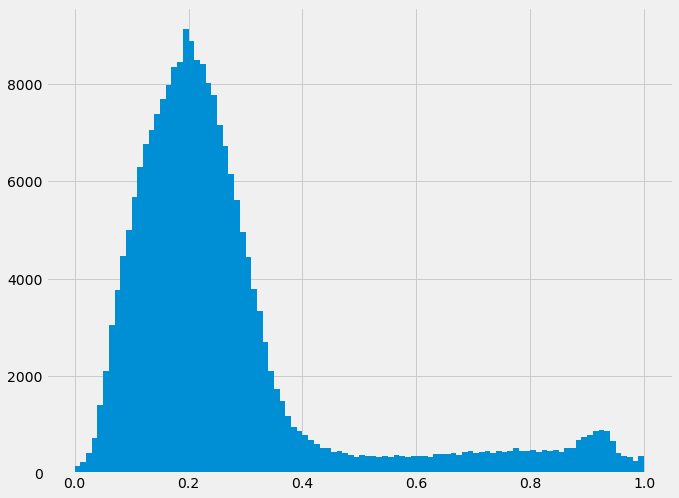

In [209]:
new_batch_stats.tmalign_score.hist(bins=100, figsize=(10,8));

In [156]:
size = 7115
step = 100
[(i*step, (i+1)*step) for i in range(int(size / step + 1))]

[(0, 100),
 (100, 200),
 (200, 300),
 (300, 400),
 (400, 500),
 (500, 600),
 (600, 700),
 (700, 800),
 (800, 900),
 (900, 1000),
 (1000, 1100),
 (1100, 1200),
 (1200, 1300),
 (1300, 1400),
 (1400, 1500),
 (1500, 1600),
 (1600, 1700),
 (1700, 1800),
 (1800, 1900),
 (1900, 2000),
 (2000, 2100),
 (2100, 2200),
 (2200, 2300),
 (2300, 2400),
 (2400, 2500),
 (2500, 2600),
 (2600, 2700),
 (2700, 2800),
 (2800, 2900),
 (2900, 3000),
 (3000, 3100),
 (3100, 3200),
 (3200, 3300),
 (3300, 3400),
 (3400, 3500),
 (3500, 3600),
 (3600, 3700),
 (3700, 3800),
 (3800, 3900),
 (3900, 4000),
 (4000, 4100),
 (4100, 4200),
 (4200, 4300),
 (4300, 4400),
 (4400, 4500),
 (4500, 4600),
 (4600, 4700),
 (4700, 4800),
 (4800, 4900),
 (4900, 5000),
 (5000, 5100),
 (5100, 5200),
 (5200, 5300),
 (5300, 5400),
 (5400, 5500),
 (5500, 5600),
 (5600, 5700),
 (5700, 5800),
 (5800, 5900),
 (5900, 6000),
 (6000, 6100),
 (6100, 6200),
 (6200, 6300),
 (6300, 6400),
 (6400, 6500),
 (6500, 6600),
 (6600, 6700),
 (6700, 6800),
 